# Homework description

In this assignment we are going to train a neural network for noise reduction.

The total cost of this assignment is 15 pts.

**Get ready, this assignment is huge!**

## Plan:
0. Datasets
1. Volume normalization, gain, RMS: everything we need to mix signal with noise [2 points]
2. Room impulse response (RIR): what we need to simulat acoustics and perform partial dereverberation [1 point]
3. On-the-fly data generation [5 points]
4. Neural network architecture [3 points]
5. Loss function [2 point]
6. Train Loop [2 points]

## A homework submission should include:
1. filled notebook
2. tensorboard logs
3. 5 examples of input-output files from the trained model in .wav format

## Note!
If submission requirements are not satisfied we keep the right not to accept the work!

# 0. Datasets

We are going to use clean speech and room impluse responses from DNS Challenge dataset.
For speech it is random subsample, for RIR we shall use the full smallroom partition to avoid extreme reverberation levels.

Originally DNS Challenge data comes in 48 kHz sample rate. We [down-sampled](https://librosa.org/doc/0.11.0/generated/librosa.resample.html#librosa-resample) it to 16 kHz in advance.

For noise we are going to use Musan dataset. Why not DNS Challenge data? Training progress will be seen faster with Musan.

Let's download the data:

In [1]:
from io import BytesIO
import os
import requests
from urllib.parse import urlencode
from zipfile import ZipFile

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/ECHrgBGJrrGQqw'

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
response = requests.get(download_url)

path_to_dataset = 'data'    # Choose any appropriate local path

zipfile = ZipFile(BytesIO(response.content))
zipfile.extractall(path=path_to_dataset)

In [1]:
import os

path_to_dataset = 'data'

ROOT_DATA = os.path.join(path_to_dataset, "homework_1_16kHz")

DATA_PATHS = {
    "speech": os.path.join(ROOT_DATA, "clean_train"),
    "noise": os.path.join(ROOT_DATA, "musan/noise"),
    "rir": os.path.join(ROOT_DATA, "impulse_responses_all/SLR26/simulated_rirs_48k/smallroom"),
}

How many audio files do we have?

In [2]:
from glob import glob


def list_wavs_in_folder_recursively(path: str) -> list[str]:
    return sorted(glob(os.path.join(path, "**", "*.wav"), recursive=True))

for key, folder in DATA_PATHS.items():
    paths = list_wavs_in_folder_recursively(folder)
    print(f"{key}: {len(paths)}")

speech: 10025
noise: 930
rir: 20000


The full dataset contains about 1M speech utterances, 64k noise samples and 63k impulse responses. The dataset is available in 48 kHz samplerate.

In [3]:
from __future__ import annotations

import librosa  # to plot mel-spectrograms
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import scipy.signal as sig
from tqdm.notebook import tqdm

SR = 16_000

This is a utility function which we shall use to view spectrograms:

In [4]:
def build_spec_for_plot(waveform):
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=SR)
    min_val = 1e-10
    mel_spec = np.clip(mel_spec, min_val, None)
    mel_spec[-1, -1] = min_val
    mel_spec_db = 10 * np.log10(mel_spec)
    return np.flip(mel_spec_db, axis=0)

**Let's select sample files**

In [5]:
rel_path = "read_speech/book_00007_chp_0008_reader_01326_64_seg_2.wav"
SAMPLE_SIGNAL, _sr = sf.read(os.path.join(DATA_PATHS["speech"], rel_path))

rel_path = "free-sound/noise-free-sound-0001.wav"
SAMPLE_NOISE, _sr = sf.read(os.path.join(DATA_PATHS["noise"], rel_path))

SAMPLE_RIR, _sr = sf.read(os.path.join(
    ROOT_DATA,
    "impulse_responses_all/SLR28/RIRS_NOISES/real_rirs_isotropic_noises/air_type1_air_binaural_office_0_1_1ch.wav",
))

# 1. Volume normalization, gain, RMS: everything we need to mix signal with noise [2 points]

## RMS-full-scale

Let's suppose we have an audio signal $x=(x[0], x[1], ..., x[T-1])$.

A basic measure of its loundness would be its L2-norm. It is also referred to as RMS (root-mean-square):
$$\text{rms}_{\text{raw}}(x) = ||x|| = ||x||_2 = \sqrt{\frac{1}{T}\sum_{t=0}^{T-1} x[t]^2}$$

It is convenient to express RMS in decibels. Decibels involve logarithm computation and are only applicable to dimensionless physical quantities, typically to ratios.

So we need to define a reference value to normalize by. As signals are represented with floating-point values ranged between -1 and 1, 2 options are typically adopted:

$$\text{rms}_{\text{ref}, \sin} = \int_{0}^{2\pi} sin^2(t)dt = 0.5$$
which corresponds to rms of a sine wave , or
$$\text{rms}_{\text{ref, square}} = 1$$
the latter corresponds to rms of a [square wave](https://en.wikipedia.org/wiki/Square_wave).

Both options are used, leading to confusion in the industry.

In this assignment **let's use:**
$$\text{rms}_{\text{ref}} = \text{rms}_{\text{ref, square}} = 1$$

Thus we get:

$$\text{rms}_\text{dB}(x) = 20\log_{10}\frac{||x||}{\text{rms}_{\text{ref, square}}} = 20\log_{10}||x|| = 10\log_{10}\frac{1}{T}\sum_{t=0}^{T-1}x[t]^2$$

**The latter is called RMS-full-scale (or RMS-fs)**, i.e. RMS relative to full scale of 1.

In [6]:
def eval_mean_square(x: np.ndarray) -> float:
    """
    Computes mean-square of x
    """
    return np.sqrt(np.mean(x ** 2))


def power_to_db(x: float) -> float:
    """
    Computes 10log10(x)
    """
    return 10 * np.log10(x)


def eval_rms_db(x: np.ndarray) -> float:
    """
    Computes rms-fs of x
    """
    rms_square_raw = eval_mean_square(x)
    rms_db = power_to_db(rms_square_raw ** 2)
    return rms_db

In [7]:
eps = 1e-12

assert abs(power_to_db(0.01) + 20) < eps
assert abs(power_to_db(0.1) + 10) < eps
assert abs(power_to_db(1) - 0) < eps
assert abs(power_to_db(10) - 10) < eps
assert abs(power_to_db(100) - 20) < eps

assert abs(eval_rms_db(np.ones(999) * 0.1) + 20) < eps
assert abs(eval_rms_db(np.ones(999) * 1) - 0) < eps
assert abs(eval_rms_db(np.ones(531) * 10) - 20) < eps

## Gain, normalization

When a signal $x$ is multiplied by a scalar factor of $\alpha \geq 0$, it corresponds to addition in the world of decibels:
$$\text{rms}_\text{dB}(\alpha x) = 20 \log_{10} ||\alpha x|| = 20\log_{10}\alpha + 20\log_{10} ||x|| = 20\log_{10}\alpha + \text{rms}_\text{dB}(x)$$

The multiplication of $x$ by $\alpha \geq 0$ is often referred to as **gain by $\boldsymbol{G}$ dB**, where $G = 20\log_{10}\alpha$, which can be both positive or negative (or even infinite negative if $\alpha=0$).

The inverse relationship can be inferred to express the scalar factor from the gain in decibels:

In [8]:
def gain_to_mult(gain_db: float) -> float:
    """
    Finds the positive scalar factor which corresponds to given gain_db
    """
    return 10 ** (gain_db / 20)
    
    
def mult_to_gain(mult: float) -> float:
    """
    Finds the gain in dB from positive scalar factor
    """
    return 20 * np.log10(mult)

In [9]:
eps = 1e-12

assert abs(gain_to_mult(-20) - 0.1) < eps
assert abs(gain_to_mult(0) - 1) < eps
assert abs(gain_to_mult(20) - 10) < eps

for mult in [1., 0.265, 10.5]:
    gain_db = mult_to_gain(mult)
    mult_power = mult ** 2  # if x is multiplied by mult, x ** 2 is multiplied by mult ** 2
    gain_db_from_power = power_to_db(mult_power)
    assert abs(gain_db_from_power - gain_db) < eps
    mult_restored = gain_to_mult(gain_db)
    assert abs(mult - mult_restored) < eps

Now we know how to apply gain in decibels:

In [10]:
def apply_gain(x: np.ndarray, gain_db: float) -> np.ndarray:
    mult = gain_to_mult(gain_db)
    result = x * mult
    return result

In [11]:
x = np.ones(10)

assert np.allclose(apply_gain(x, -20), x / 10)
assert np.allclose(apply_gain(x, 0), x)
assert np.allclose(apply_gain(x, 20), x * 10)


for _ in range(100):
    x = np.random.uniform(-1, 1, 16_000)
    gain = np.random.uniform(-20, 20)
    rms_before = eval_rms_db(x)
    rms_expected = rms_before + gain
    
    gained = apply_gain(x, gain)
    rms_after = eval_rms_db(gained)
    
    assert abs(rms_after - rms_expected) < 1e-12

Let's implement a function which will normalize an input signal to a desired level of $\text{rms}_\text{dB}$.

How should it work?

1. Calculate $\text{rms}_\text{dB}(\text{signal})$
2. Calculate gain in decibels: $g = \text{rms}_\text{dB, target} - \text{rms}_\text{dB}(\text{signal})$
3. Translate the gain to the linear scale (`db_to_linear` could be a better name for the `gain_to_mult` function)
4. Multiply input signal by the linear-scale gain

In [12]:
def get_normalization_mult(x: np.ndarray, target_rms_db: float) -> float:
    """
    Calculates a mult such that rms_db(x * mult) == target_rms_db
    """
    rms_db_cur = eval_rms_db(x)
    gain_db = target_rms_db - rms_db_cur
    mult = gain_to_mult(gain_db)
    return mult


def normalize_to_rms(x: np.ndarray, target_rms_db: float) -> np.ndarray:
    """
    Normalizes signal x to target_rms_db
    """

    mult = get_normalization_mult(x, target_rms_db)
    return x * mult

In [13]:
for _ in range(100):
    x = np.random.uniform(-1, 1, 16_000)
    target_rms_db = np.random.uniform(-20, 20)
    normalized = normalize_to_rms(x, target_rms_db)
    rms_after_normalization = eval_rms_db(normalized)
    assert abs(target_rms_db - rms_after_normalization) < 1e-12
    
print("Ok")

Ok


**Let's play with it:**

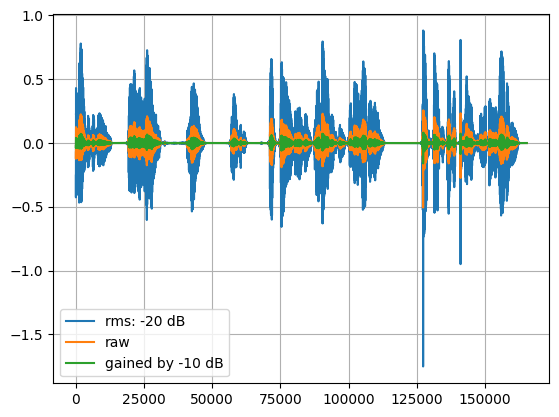

In [14]:
x = np.copy(SAMPLE_SIGNAL)

gain_db = -10
x_gained = apply_gain(x, gain_db)
x_normalized = normalize_to_rms(x, -20)

_, ax = plt.subplots()
ax.plot(x_normalized, label="rms: -20 dB")
ax.plot(x, label="raw")
ax.plot(x_gained, label=f"gained by {gain_db} dB")
ax.legend()
ax.grid()
plt.show()

### SNR

SNR (signal-to-noise ratio) is expressed in decibels and is defined as:

$$\text{SNR} = 10\log_{10}\frac{||\text{signal}||^2}{||\text{noise}||^2} = 10\log_{10}||\text{signal}||^2 - 10\log_{10}||\text{noise}||^2 = \text{rms}_{\text{dB}}(\text{signal}) - \text{rms}_{\text{dB}}(\text{noise})$$

Also, **SNR can be used as a quality metrics** or even a loss function for gradient descent.

Given a ground truth signal $y$ and its estimate $\hat y$, we define noise as $\hat y - y$. Slightly abusing notation we get:

$$\text{SNR}(\hat y, y) = 10 \log_{10} \frac{||y||^2}{||\hat y - y||^2}$$

In [15]:
def eval_snr(estimate: np.ndarray, signal: np.ndarray) -> float:
    """
    evaluates SNR as a quality metrics
    """
    return eval_rms_db(signal) - eval_rms_db(estimate - signal)

In [16]:
for _ in range(100):

    signal = np.random.uniform(-1, 1, 16_000)
    noise = np.random.uniform(-1, 1, 16_000) * np.random.uniform(0.3, 2)
    mixture = signal + noise
    snr = eval_rms_db(signal) - eval_rms_db(noise)
    snr_est = eval_snr(mixture, signal)
    assert abs(snr - snr_est) < 1e-12

Now we have everything to generate a mixture of speech and noise with defined signal loudness (RMS) and SNR:

1. Normalize signal to $\text{rms}_\text{target, signal}$
2. Noramlize noise to $\text{rms}_\text{target, noise} = \text{rms}_\text{target, signal} - \text{SNR}$
3. Add noise to signal. What if shapes don't match? Let's just assume they match and enforce it outside the function.

In [17]:
def mix_speech_with_noise(signal, noise, rms_signal, snr):
    signal_normalized = normalize_to_rms(signal, rms_signal)
    rms_noise_target = rms_signal - snr
    noise_normalized = normalize_to_rms(noise, rms_noise_target)
    mixture = signal_normalized + noise_normalized
    return mixture

In [18]:
for _ in range(100):
    signal = np.random.uniform(-1, 1, 16_000)
    noise = np.random.uniform(-1, 1, 16_000) * np.random.uniform(0.3, 2)
    rms_signal = np.random.uniform(-20, 20)
    snr = np.random.uniform(-20, 20)
    mixture = mix_speech_with_noise(signal, noise, rms_signal, snr)
    
    signal_gained = normalize_to_rms(signal, rms_signal)
    snr_est = eval_snr(mixture, signal_gained)

    assert abs(snr - snr_est) < 1e-12
    
print("Ok")

Ok


Let's mix speech signal with noise on different SNR's and look at the spectrograms:

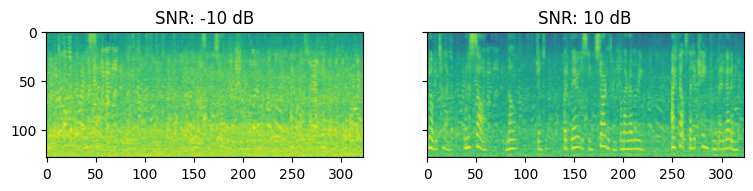

In [19]:
snr_vals = [-10, 10]
_, axes = plt.subplots(ncols=2, figsize=(9, 4), sharex=True, sharey=True)
for snr_idx, snr in enumerate(snr_vals):
    min_len = min(len(SAMPLE_SIGNAL), len(SAMPLE_NOISE))
    signal = SAMPLE_SIGNAL[:min_len]
    noise = SAMPLE_NOISE[:min_len]

    mixture = mix_speech_with_noise(signal, noise, -30, snr)

    spec = build_spec_for_plot(mixture)
    ax = axes[snr_idx]
    ax.set_title(f"SNR: {snr} dB")
    ax.imshow(spec)
plt.show()

# 2. Room impulse response (RIR): what we need to simulat acoustics and perform partial dereverberation [1 point]

The common approach to simulate acoustics is convolving signal with room impulse response (RIR).

It follows from the linear acoustic model (which is accurate enough to be used in practice) and the assumption of time-invariance (i.e. that room acoustics does not change over time or it changes slowly).

For input signal $x$ and RIR $r$:

$$x_{\text{reverberated}} = x * r$$

A RIR is defined as the reverberated version of the unit impulse, i.e. the (1, 0, 0, 0, ...) signal.

An RIR can be listened to and it sounds like a click.

**Let's take a look at an impulse response.**

This will be a real impulse response from a relatively highly reverberant environment.

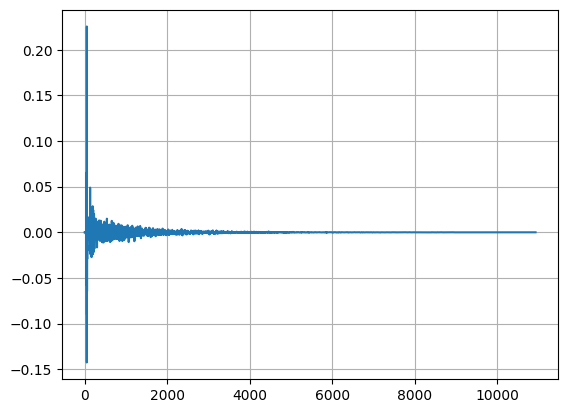

In [20]:
rir = np.copy(SAMPLE_RIR)

_, ax = plt.subplots()
ax.plot(rir)
ax.grid()
plt.show()

**This is how a RIR is convolved with a signal**

In [21]:
convolved = sig.convolve(SAMPLE_SIGNAL, SAMPLE_RIR, mode="full")

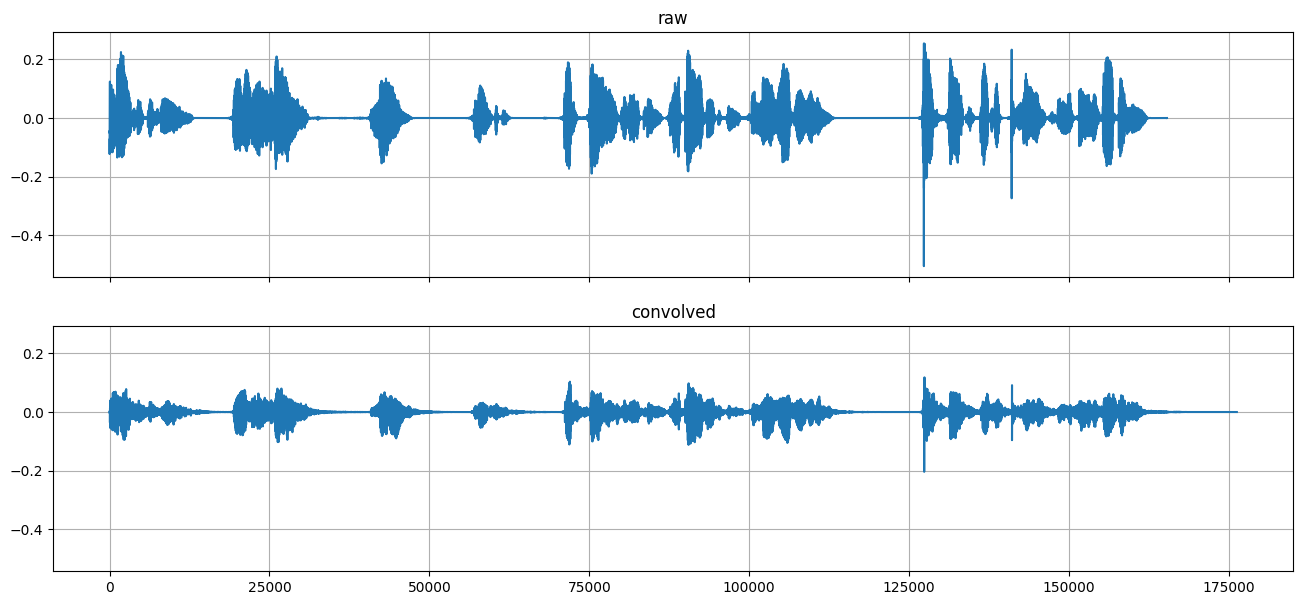

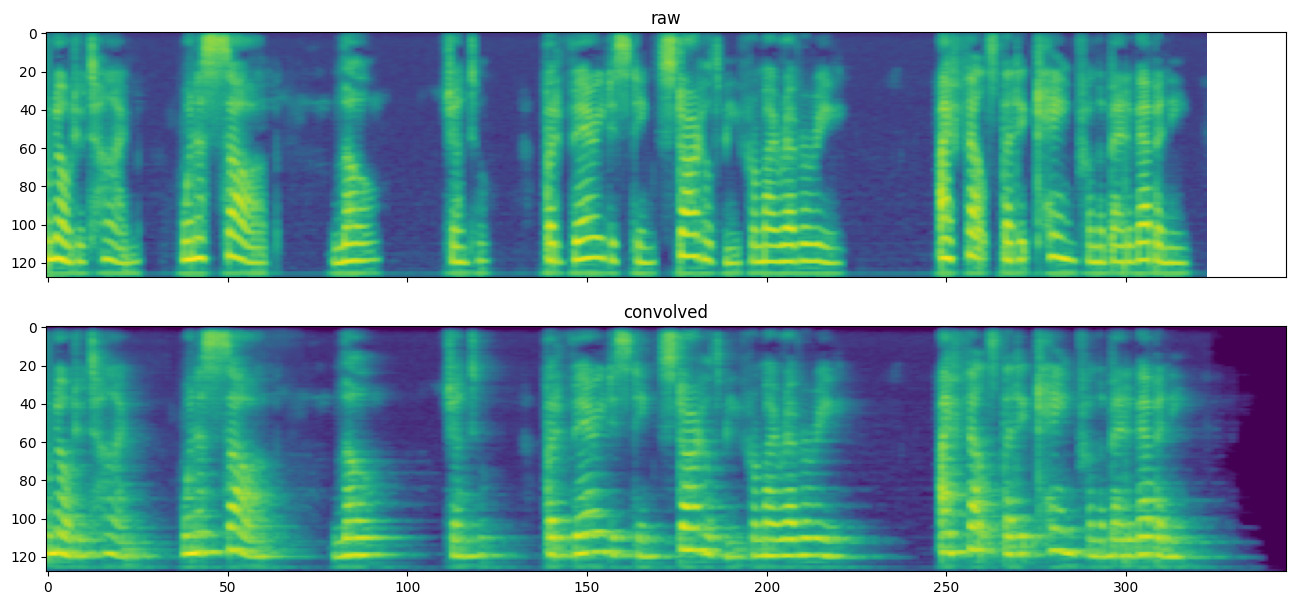

In [22]:
_, axes = plt.subplots(nrows=2, figsize=(16, 7), sharex=True, sharey=True)
for ax, (name, data) in zip(axes, [
    ("raw", SAMPLE_SIGNAL),
    ("convolved", convolved),
]):
    ax.set_title(name)
    ax.plot(data)
    ax.grid()
plt.show()

_, axes = plt.subplots(nrows=2, figsize=(16, 7), sharex=True, sharey=True)
for ax, (name, data) in zip(axes, [
    ("raw", SAMPLE_SIGNAL),
    ("convolved", convolved),
]):
    spec = build_spec_for_plot(data)
    ax.set_title(name)
    ax.imshow(spec)
    ax.set_aspect("auto")
plt.show()

**Note the shapes:**

In [23]:
assert len(convolved) == len(SAMPLE_SIGNAL) + len(SAMPLE_RIR) - 1

The output file is longer, and as it can be seen from the spectrum, the appended length mainly consists of the reverberation tail.

**Let's take a closer look what a RIR looks like**

**These are helper functinons** which evaluate windowed power of a signal (RIR) and plot it in the dB scale:

In [24]:
def get_win_power(rir, win_size=160):
    win = np.hanning(win_size)
    win /= win.sum()
    rir_sq = np.square(rir)
    win_power = sig.convolve(rir_sq, win, mode="valid")
    return win_power


def plot_win_power_db(win_power_db, ax):
    lines = ax.plot(win_power_db)
    return lines[0]


def plot_rir_for_rt60(rir, ax):
    win_power = get_win_power(rir)
    win_power_db = 10 * np.log10(win_power)
    line = plot_win_power_db(win_power_db, ax)
    return line

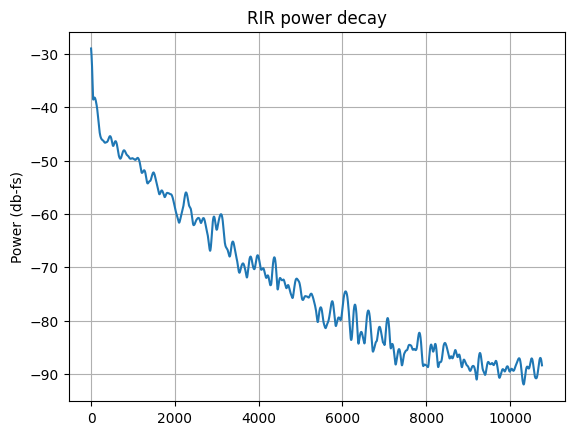

In [25]:
_, ax = plt.subplots()
win_power = get_win_power(SAMPLE_RIR)
win_power_db = 10 * np.log10(win_power)
plot_win_power_db(win_power_db, ax)
ax.set_title("RIR power decay")
ax.set_ylabel("Power (db-fs)")
ax.grid()
plt.show()

**We can oberve the following pattern:**

First the power drops abruptly and then it decays by a linear pattern in the log scale.

The slope of the linear fit defines the $\boldsymbol{rt_{60}}$ property of a RIR (and even a room).

$\boldsymbol{rt_{60}}$ (reverb time 60) is the time in which the linear fit decays by 60 dB. Measured in seconds.

Why 60 dB? It is the difference between the loudest and the quietest volumes in a symphonic orchestra.

**For the curious:** [More about rt60](https://svantek.com/academy/rt60-reverberation-time/), they measure it directly, not from an RIR.

**Let's fit a linear regression estimator:**

In [26]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()

linear_trend_start = 500
linear_trend_end = 8000

x = np.arange(linear_trend_end)[linear_trend_start: linear_trend_end]
y = win_power_db[linear_trend_start: linear_trend_end]

linear_regression.fit(x[:, None], y);
linear_fit = linear_regression.predict(x[:, None])

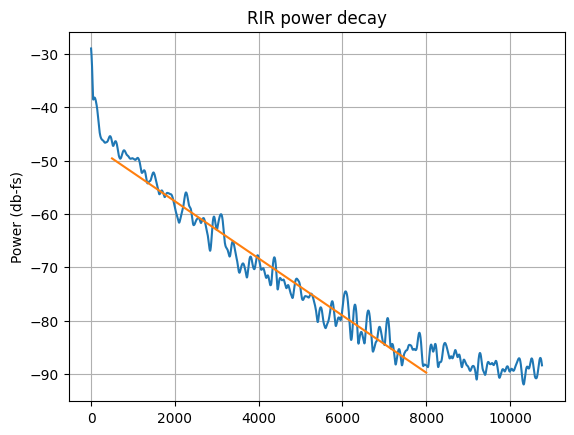

In [27]:
_, ax = plt.subplots()

ax.set_title("RIR power decay")
ax.set_ylabel("Power (db-fs)")
plot_rir_for_rt60(SAMPLE_RIR, ax)
ax.plot(x, linear_fit)
ax.grid()

plt.show()

In [28]:
coef = linear_regression.coef_.item()
# intercept = linear_regression.intercept_
rt_60_sec = -60 / (coef * SR)

print(f"RT60 of our RIR is {rt_60_sec} seconds")
assert abs(rt_60_sec - 0.7) < 0.02, rt_60_sec

RT60 of our RIR is 0.7008849264158727 seconds


In [29]:
print(rt_60_sec)

0.7008849264158727


**RIR decay**

For targets of partial dereverberation RIR is decayed.

How we will do it:

1. Find the argmax of a RIR. Keep the part of RIR before argmax unchanged: it corresponds to the direct sound pass.

2. The rest part should be decayed exponentially, -60 dB per 0.3 sec, i.e. $T_{60}=0.3 \text{ sec}$.

This procedure is defined in the [Cruse](https://arxiv.org/pdf/2101.09249.pdf) paper, a similar approach was used in [PoCoNet](https://arxiv.org/pdf/2008.04470.pdf).

![title](assets/pictures/CRUSE_RIR_Shaping.png)

In [30]:
def decay_rir(rir: np.ndarray, decay_rt_60_sec = 0.3, sr=SR) -> np.ndarray:
    """
    Decays a RIR as described above
    """
    main_tap = np.argmax(rir).item()

    part_to_decay = rir[main_tap:]
    T_60_max_sec = 0.3
    T_60_max_frames = int(T_60_max_sec * sr)
    gain_db = -60 * np.arange(len(part_to_decay)) / T_60_max_frames # your code: -60 per T_60_max_frames, same len as part_to_decay
    gain_linear = [gain_to_mult(gain) for gain in gain_db] # convert gain_db into a linear mult
    part_decayed = part_to_decay * gain_linear
    rir_decayed = np.concatenate([rir[:main_tap], part_decayed])
    return rir_decayed


rir_decayed = decay_rir(rir)

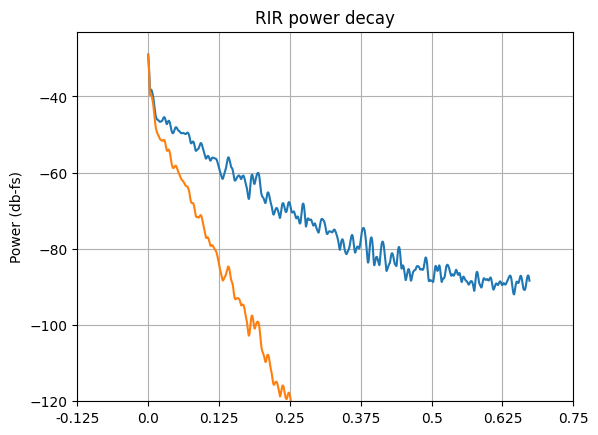

In [31]:
_, ax = plt.subplots()

ax.set_title("RIR power decay")
ax.set_ylabel("Power (db-fs)")
plot_rir_for_rt60(rir, ax)
plot_rir_for_rt60(rir_decayed, ax)

ax.set_ylim(-120, -23)
x_ticks = ax.get_xticks()
x_tick_labels = x_ticks / SR
ax.set_xticks(x_ticks, x_tick_labels)
ax.grid()

plt.show()

We don't provide and assertion test here, but this is what it should look like.

Pay attention to your decay rate, it should not deviate too much.

![title](assets/pictures/rir_shaping_ours.png)

# 3. On-the-fly data generation [5 points]

**Why?**

We are going to train a model on synthetic mixtures of signals, noises with acoustics simulation via RIR convolution.

Why do we train a model on synthetic data? It is the most straight-forward way to obtain corresponding (mixture, signal) pairs.

It can seem natural to simulate all the data in advance and train on it.

But we shall take another approach: we will generate training mixtures on-the-fly. Data will be generated in parallel with forward-backward passes on GPU -- thanks to PyTorch's DataLoader class.

Generating data on the fly we can both increate training data diversity and save disk storage.

**Efficent audio chunk reading:**

We are going to train on fixed-length chunks of audio.

A naive approach to read a chunk of audio file would be to read the full file and then crop it.

But we can do it better.

`sf.read` function provides `start` and `stop` arguments. When provided, the `audio[start: stop]` segment is read directly without reading the whole file.

In [32]:
rel_path = "read_speech/book_00000_chp_0009_reader_06709_11_seg_0.wav"
path = os.path.join(DATA_PATHS["speech"], rel_path)

x, _sr = sf.read(path)
print(f"total audio file duration: {len(x)} frames or {len(x) / SR} seconds")

crop_size_sec = 1
crop_size_frames = int(crop_size_sec * SR)

start = 16_000
stop = start + crop_size_frames

total audio file duration: 165334 frames or 10.333375 seconds


In [33]:
%%timeit

x = sf.read(path)[0][start: stop]

694 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%%timeit

x, _sr = sf.read(path, start=start, stop=stop)

147 µs ± 1.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Let's implement a class that will read raw signal and noise data:**

In [35]:
class SignalSampler:
    def __init__(
        self,
        paths: list[str],
        crop_size_sec: float = 5.0,
        min_rms_db: float | None = -38,
        sr: int = SR,
    ) -> None:
        """
        paths: list of absolute paths to the files we are going to sample from
        crop_size_sec: the size of generated chunks, in seconds
        min_rms_db: chunks with RMS lower than this should be discarded
        sr: samplerate
        """
        self.paths = paths
        self.crop_size_frames = int(crop_size_sec * sr)
        self.min_rms_db = min_rms_db
        self.sr = sr

    def _sample_from_single_file(
        self, path: str, crop_size_frames: int | None = None
    ) -> np.ndarray:
        """
        Reads a random crop of size crop_size_frames from path.
        If the file is shorter, reads the full file.
           
        Use sf.read(..., start=start_index, stop=end_index) to read
        chunks efficiently.
        """
        if crop_size_frames is None:
            crop_size_frames = self.crop_size_frames
        with sf.SoundFile(path) as f:
            if f.samplerate != self.sr:
                assert False, (path, f.samplerate, self.sr)
            file_duration_frames: int = f.frames
        if file_duration_frames < crop_size_frames:
            x, _sr = sf.read(path)
            return x
        # to avoid the +-1 mistake, keep in mind the corner case when file_duration_frames == crop_size_frames
        if file_duration_frames - crop_size_frames == 0:
            start = 0
        else:
            start = np.random.randint(0, file_duration_frames - crop_size_frames + 1)
        stop = start + crop_size_frames
        x, _sr = sf.read(path, start=start, stop=stop)
        return x

    def __call__(self) -> np.ndarray:
        """
        Generates a chunk of audio data of length self.crop_size_frames.
        
        1. Samples a random file from self.paths
        
        2. Reads its random crop of the target size (initialized as self.crop_size_frames).
           If the file is shorter, reads the full file.
           <this should be done in self._sample_from_single_file>
           
        3. Checks RMS of the crop.
           The crop is discarded if its rms is lower than self.min_rms_db.
           Otherwise it is accumulated
           
        4. Returns the concatenation of accumulated crops
           if their total length reaches self.crop_size_frames.
           Otherwise sets target size (for 2) to n_frames_ramaining and repeats 1-4
        """
        chunks: list[np.ndarray] = []
        duration_frames_remaining = self.crop_size_frames
        while duration_frames_remaining > 0:
            path = np.random.choice(self.paths)
            chunk = self._sample_from_single_file(path, duration_frames_remaining)
            if self.min_rms_db is not None:
                chunk_rms_db = eval_rms_db(chunk)
                if chunk_rms_db < self.min_rms_db:
                    continue
            chunks.append(chunk)
            duration_frames_remaining -= len(chunk)

        result = np.concatenate(chunks)

        assert result.ndim == 1, result.shape
        assert len(result) == self.crop_size_frames

        return result

In [36]:
for crop_size_sec in [1, 3]:
    for key in ["speech", "noise"]:
        print(f"crop_size_sec: {crop_size_sec}, data: {key}")
        sampler = SignalSampler(
            list_wavs_in_folder_recursively(DATA_PATHS[key]),
            crop_size_sec=crop_size_sec
        )
        n_samples = 1000
        for idx in enumerate(tqdm(range(n_samples))):
            chunk = sampler()
            assert chunk.ndim == 1, chunk.shape
            assert len(chunk) == crop_size_sec * SR, chunk.shape
        print("Ok")

crop_size_sec: 1, data: speech


  0%|          | 0/1000 [00:00<?, ?it/s]

Ok
crop_size_sec: 1, data: noise


  0%|          | 0/1000 [00:00<?, ?it/s]

Ok
crop_size_sec: 3, data: speech


  0%|          | 0/1000 [00:00<?, ?it/s]

Ok
crop_size_sec: 3, data: noise


  0%|          | 0/1000 [00:00<?, ?it/s]

Ok


**Now let's define a similar sampler for RIRs.**

This guy is simpler, because it does not read chunks: it should read full RIRs.

In [37]:
class RirSampler:
    def __init__(self, paths: list[str], sr: int = SR) -> None:
        """
        paths: list of absolute paths to the files we are going to sample from
        sr: samplerate
        """
        self.paths = paths
        self.sr = sr

    def __call__(self) -> np.ndarray:
        """
        Samples a random path and reads the full audio file from it
        """
        path = self.paths[np.random.randint(len(self.paths))]
        rir, sr = sf.read(path)
        assert sr == self.sr, (path, sr, self.sr)
        return rir

In [38]:
sampler = RirSampler(list_wavs_in_folder_recursively(DATA_PATHS["rir"]))
n_samples = 1000
for idx in enumerate(tqdm(range(n_samples))):
    rir = sampler()
    assert rir.ndim == 1, rir.shape
print("Ok")

  0%|          | 0/1000 [00:00<?, ?it/s]

Ok


**We have learnt to sample RIRs and chunks of signal/noise.**

Before we start generating synthetic mixtures, let's define **energy-based Voice Activity Detector (VAD)** and VAD-based RMS calculation.

Energy-based VAD calculates frame-level energies of a waveform and selects as active the frames where rms is higher than a threshold.

In [39]:
def calc_rms_active(wave: np.ndarray, window: np.ndarray, dynamic_range_db=30) -> tuple[float, np.ndarray]:
    """
    wave: input waveform
    window: used for frame-level energy calculation
    dynamic_range_db: frames with rms > max_rms - dynanic_range_db are treated as active
    """
    wave_sq = np.square(wave)
    assert len(window) % 2 == 1, len(window)

    assert np.all(window > 0)
    assert np.all(wave_sq >= 0)
    # frame-level energies:
    win_rms_sq = sig.convolve(wave_sq, window, mode="same")
    # numerical error can lead to negative values which break SNR
    win_rms_sq = np.clip(win_rms_sq, a_min=0, a_max=None)
    win_rms_db = power_to_db(win_rms_sq)
    max_win_rms_db = np.max(win_rms_db)
    if not np.isfinite(max_win_rms_db):
        # print(max_win_rms_db)
        return float("-inf"), np.zeros(len(wave), dtype=bool)
    activity_mask = win_rms_db > max_win_rms_db - dynamic_range_db
    rms_linear = np.sqrt(np.mean(wave_sq[activity_mask]))
    # calculate rms_linear (i.e. root-mean-square, without decibels)
    # for the masked wave (you may mask wave_sq)
    
    return rms_linear, activity_mask

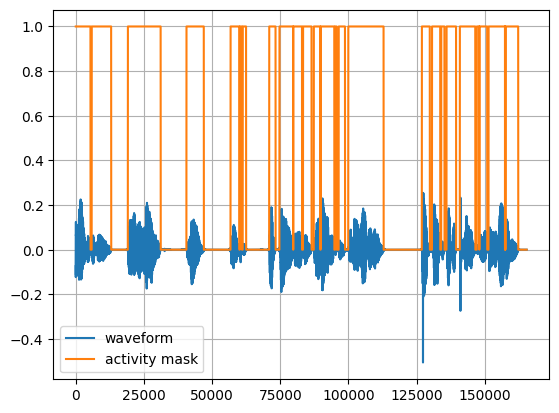

In [40]:
x = SAMPLE_SIGNAL
window = np.ones(int(0.030 * SR) + 1)
window = window / window.sum()

rms_linear, activity_mask = calc_rms_active(x, window)

# we have pre-computed the value for the test
assert abs(rms_linear - 0.03637365801906506) < 1e-5

_, ax = plt.subplots()
ax.plot(x, label="waveform")
ax.plot(activity_mask, label="activity mask")
ax.grid()
ax.legend()
plt.show()

Again, check your VAD with our reference:

![title](assets/pictures/vad_reference.png)

**Finally we are ready to generate training mixtures. Let's do it!**

We suggest you to start implementation with the `__call__` method and implement the other methods when you see them in the `__call__`.

In [41]:
def convolve_same_length(x: np.ndarray, rir: np.ndarray) -> np.ndarray:
    """
    Convoves signal with rir and crops the result to have the original shape
    """
    convolved = sig.convolve(x, rir, mode="full")
    result = convolved[: len(x)]  # we crop out the reverb-only semgent
    return result


class RandomMixtureSampler:
    """
    Inspired by PoCoNet: https://arxiv.org/pdf/2008.04470.pdf
    """

    def __init__(
        self,
        sig_sampler: tp.Callable[[], np.ndarray],  # SignalSampler
        noise_sampler: tp.Callable[[], np.ndarray],  # SignalSampler
        rir_sampler: tp.Callable[[], np.ndarray],  # RirSampler
        prob_rir_sig: float = 0.5,  # prob to convolve signal with a RIR
        prob_rir_noise: float = 0.5,  # prob to convolve noise with a RIR
        normalization_rms_db: float = -20,  # normalization level used for signal and noise before gain
        noise_gain_range_db: tuple[float, float] = (-5, 5),  # gain applied to noise
        mixture_gain_range_db: tuple[float, float] = (-25, 5),  # gain applied to final mixture
        partial_dereverb: bool = True,  # whether to do partial dereverberation
        *,
        sr: int = 16_000,  # samplerate
    ) -> None:
        self.sig_sampler = sig_sampler
        self.noise_sampler = noise_sampler
        self.rir_sampler = rir_sampler
        self.prob_rir_sig = prob_rir_sig
        self.prob_rir_noise = prob_rir_noise
        self.sr = sr

        self.normalization_rms_db = normalization_rms_db
        self.noise_gain_range_db = noise_gain_range_db
        self.mixture_gain_range_db = mixture_gain_range_db

        self.partial_dereverb = partial_dereverb
        
        rms_calc_window = np.ones(int(0.030 * SR) + 1)
        rms_calc_window = rms_calc_window / rms_calc_window.sum()
        self.rms_calc_window = rms_calc_window

    def sample_noise_rms_db(self) -> float:
        """
        Samples the rms_db for noise which is relevant before mixing with signal.

        Noise is first normlized to normalization_rms_db
        and the gain by Uniform(self.noise_gain_range_db).

        These 2 operations can be implemented as a single normalize_to_rms operation
        with the final rms.
        """
        noise_gain_db = np.random.uniform(*self.noise_gain_range_db)
        return self.normalization_rms_db + noise_gain_db

    def sample_mixture_gain(self) -> float:
        """
        Uniform(*self.mixture_gain_range_db)
        """
        return np.random.uniform(*self.mixture_gain_range_db)

    def __call__(self) -> tuple[np.ndarray, np.ndarray, float]:
        signal = self.sig_sampler()
        noise = self.noise_sampler()
        if np.random.binomial(1, self.prob_rir_sig):
            rir_signal = self.rir_sampler()
            signal_input = convolve_same_length(signal, rir_signal) # your code: convolve. This signal will be part of the input, not the target
            if self.partial_dereverb:
                rir_signal_decayed = decay_rir(rir_signal, sr=self.sr)
                signal_target = convolve_same_length(signal, rir_signal_decayed) # your code: convolve. This signal will be target, with partial dereverberation
            else:
                signal_target = np.copy(
                    signal_input
                )  # np.copy is crucial to avoid double scaling
        else:
            signal_input = signal
            signal_target = np.copy(
                signal
            )  # np.copy is crucial to avoid double scaling
        del signal
        if np.random.binomial(1, self.prob_rir_noise):
            rir_noise = self.rir_sampler()
            noise = convolve_same_length(noise, rir_noise) # your code: convolve noise with its rir

        # input_signal and mic_signal should be multiplied by the same factor to match each other
        mult_signal = get_normalization_mult(
            signal_target, self.normalization_rms_db
        )
        signal_input *= mult_signal
        signal_target *= mult_signal

        noise_rms_db = self.sample_noise_rms_db()
        noise = normalize_to_rms(noise, noise_rms_db)

        mixture = signal_input + noise

        mixture_gain_db = self.sample_mixture_gain()
        mixture_mult = gain_to_mult(mixture_gain_db)

        mixture *= mixture_mult
        signal_target *= mixture_mult

        mixture = mixture.astype(np.float32)
        signal_target = signal_target.astype(np.float32)

        rms_signal_active, _ = calc_rms_active(signal_target, self.rms_calc_window)
        # Why do we need it? We will use it for level-invariant training (you will find it somewhere below)

        return mixture, signal_target, rms_signal_active

In [42]:
for crop_size_sec in [1, 5]:
    print(f"crop_size_sec: {crop_size_sec}")
    sampler = RandomMixtureSampler(
        sig_sampler=SignalSampler(
            list_wavs_in_folder_recursively(DATA_PATHS["speech"]),
            crop_size_sec=crop_size_sec
        ),
        noise_sampler=SignalSampler(
            list_wavs_in_folder_recursively(DATA_PATHS["noise"]),
            crop_size_sec=crop_size_sec
        ),
        rir_sampler=RirSampler(
            list_wavs_in_folder_recursively(DATA_PATHS["rir"])
        ),
    )
    n_samples = 1000
    for idx in enumerate(tqdm(range(n_samples))):
        mixture, signal, rms_signal = sampler()
        assert len(mixture) == len(signal) == crop_size_sec * SR, chunk.shape
    print("Ok")

crop_size_sec: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Ok
crop_size_sec: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

Ok


**Sanity check**

It is easy to leave bugs with gains. Here is a simple way to check it.

We should listen to: mixture, signal and the difference: (mixture - signal).

The difference is the sum of noise and late reverberation. No distinct signal should stay there.

An even simpler sanity check: turn partial dereverberation off in the sampler. Then difference should be the noise and it should not contain any trace of the speech signal.

Let's generate some tracks in 2 modes:
1. No-dereverb
2. Full

In [43]:
def show_samples(sampler, n_samples=4):
    _, axes = plt.subplots(ncols=3, nrows=n_samples, figsize=(16, 10), sharex=True, sharey=True)
    axes[0, 0].set_title("Mixture")
    axes[0, 1].set_title("Target")
    axes[0, 2].set_title("Interference")
    for sample_idx in range(n_samples):
        mixture, target, speech_rms_linear = sampler()
        interference = mixture - target
        
        speech_rms_db = mult_to_gain(speech_rms_linear)

        spec_mixture = build_spec_for_plot(mixture)
        spec_target = build_spec_for_plot(target)
        spec_interf = build_spec_for_plot(interference)

        ax = axes[sample_idx][0]
        ax.imshow(spec_mixture)
        ax.set_aspect("auto")

        ax = axes[sample_idx][1]
        ax.imshow(build_spec_for_plot(target))
        ax.set_xlabel(f"RMS dBFS: {speech_rms_db:.1f}")
        ax.set_aspect("auto")

        ax = axes[sample_idx][2]
        ax.imshow(build_spec_for_plot(interference))
        ax.set_aspect("auto")
    plt.show()

dereverb off:


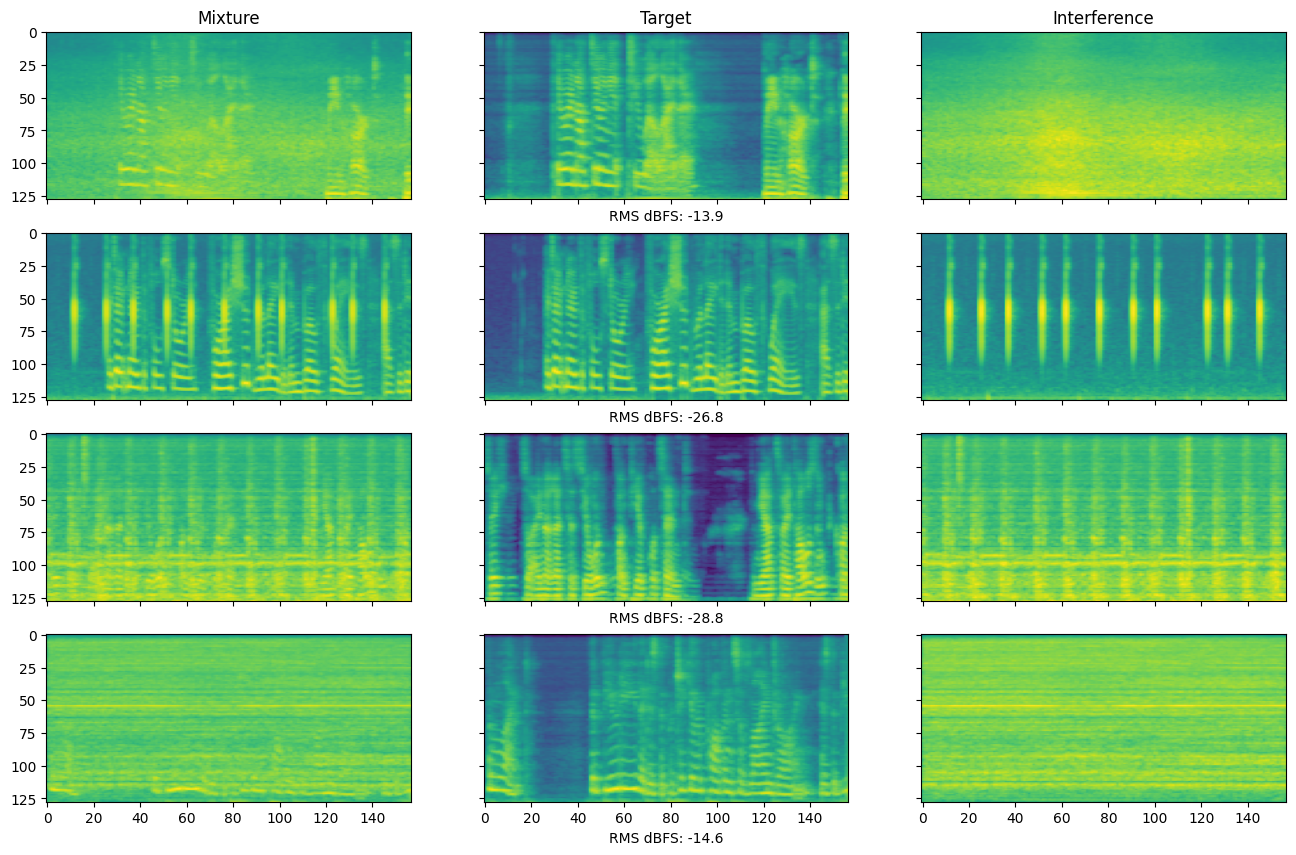

**************************************************
Full


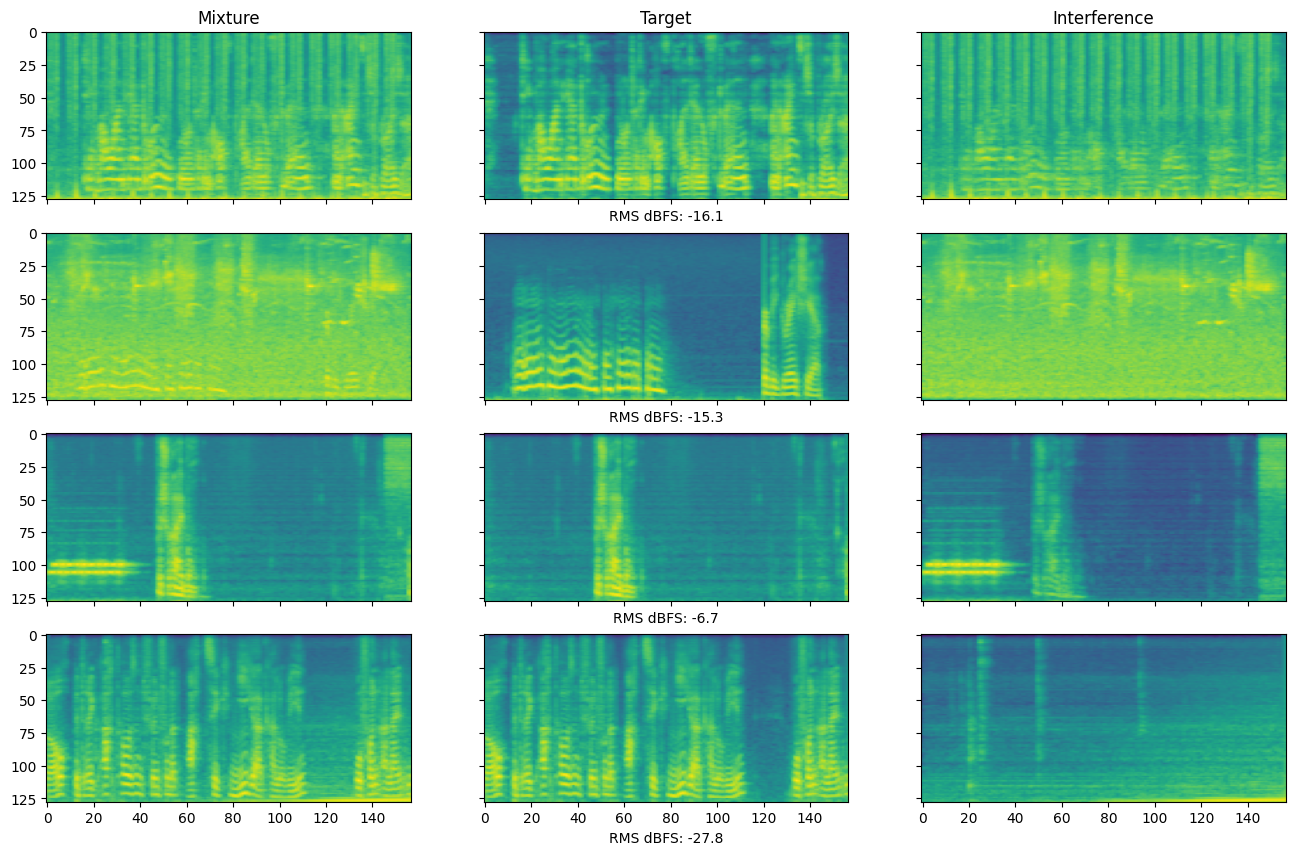

In [44]:
crop_size_sec = 5

sig_sampler = SignalSampler(
    list_wavs_in_folder_recursively(DATA_PATHS["speech"]),
    crop_size_sec=crop_size_sec
)
noise_sampler = SignalSampler(
    list_wavs_in_folder_recursively(DATA_PATHS["noise"]),
    crop_size_sec=crop_size_sec
)
rir_sampler = RirSampler(list_wavs_in_folder_recursively(DATA_PATHS["rir"]))

print("dereverb off:")
sampler = RandomMixtureSampler(
    sig_sampler=sig_sampler,
    noise_sampler=noise_sampler,
    rir_sampler=rir_sampler,
    partial_dereverb=False,
)
show_samples(sampler)
print("*" * 50)

print("Full")
sampler = RandomMixtureSampler(
    sig_sampler=sig_sampler,
    noise_sampler=noise_sampler,
    rir_sampler=rir_sampler,
)
show_samples(sampler)

**Again, our reference images.**

Withour dereverb (note the interferences are speech-free):
![title](assets/pictures/ref_gen_samples_no_dereverb.png)

With dereverb (note residual speech in some of the interferences)
![title](assets/pictures/ref_gen_samples_with_dereverb.png)

**Wrapping our sampler to PyTorch Dataset**

On `__getitem__` it will ignore the input and return a sampler from the sampler.
We also define `dummy_duration` variable which will simulate the size of a dataset.

In [45]:
import torch
import torch.utils.data as Data


class Dataset(Data.Dataset):
    def __init__(self, sampler: RandomMixtureSampler, dummy_duration: int):
        self.sampler = sampler
        self.dummy_duration = dummy_duration

    def __len__(self) -> int:
        return self.dummy_duration

    def __getitem__(self, index):
        """
        Ignores index and a sample from self.sampler, converted to float32
        """
        mixture, target, rms_signal = self.sampler()
        mixture = mixture.astype(np.float32)
        target = target.astype(np.float32)
        return mixture, target, rms_signal

    
sampler = RandomMixtureSampler(
    sig_sampler=sig_sampler,
    noise_sampler=noise_sampler,
    rir_sampler=rir_sampler,
)
dataset = Dataset(sampler, 100_000)
dataset[0]

(array([ 0.06073756,  0.05914493,  0.05655083, ..., -0.00242874,
        -0.00801986, -0.01274067], dtype=float32),
 array([-2.7723678e-18,  2.5370517e-07,  4.5666928e-07, ...,
         7.3989423e-04, -3.7686643e-03, -7.6229083e-03], dtype=float32),
 0.014575783)

Now we can use PyTorch DataLoader with our sampler, which should be really fast. If the throughput is higher that 10 batches per second (note that it outputs batches, not single samples), it is more than enough.

Pay attention to the `num_workers` parameter.

In [46]:
def worker_init_fn(worker_id):
    """
    setting different numpy seeds for different workers
    
    Without it all the DataLoader's workers will produce identical result.
    We had a pitty bug here in spring 2024.
    """
    seed = torch.randint(2 ** 32, (1,)).item()
    print(f"worker_id: {worker_id} setting seed to: {seed}")
    np.random.seed(seed)
    
    
loader = Data.DataLoader(
    dataset, batch_size=10, num_workers=8,
    worker_init_fn=worker_init_fn
)

for idx, batch in enumerate(tqdm(loader)):
    if idx == 100:
        break

  0%|          | 0/10000 [00:00<?, ?it/s]

worker_id: 1 setting seed to: 2059789017worker_id: 3 setting seed to: 4074939236worker_id: 0 setting seed to: 1620805767
worker_id: 2 setting seed to: 169009501


worker_id: 4 setting seed to: 325153942
worker_id: 5 setting seed to: 2024236048
worker_id: 7 setting seed to: 1434481509worker_id: 6 setting seed to: 1968761085



/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


**Data is ready**

# 4. Neural Network Architecture [3 points]

**Whoa, we've reached this point.** Good job, but it's still quite a way to go though.

Our model will be a 2-dimensional UNet with Dual-path RNN inside. It will perform complex spectral masking and its input will be a power-law compressed complex spectrogram.

Our UNet will do down-sampling for both time and requency axes and the convolutions in encoder-decoder will not be causal. Why? Down-sampling saves a lot of computations and we don't want this task to be overly demanding for GPU.

Feature maps will be of shape (b, c, t, f): (batch, channels, time, frequencies) for the convolutional layers. For DPRNN part we will use the (b, t, f, c) layout.

In [47]:
import torch
import torch.nn as nn
import torchaudio as tha

**Here we define the UNet engine.**

STFT, Power-law compression and masking logic will be done later.

UNet encoder-decoder is custom and pretty typical.

Please, refer to the lecture or [DPCRN](https://arxiv.org/pdf/2101.09249.pdf) paper for Band-split RNN definition.

In [48]:
class EncoderBlock(nn.Sequential):
    def __init__(self, c_in: int, c_out: int):
        super().__init__(
            nn.Conv2d(c_in, c_out, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(c_out),
            nn.PReLU()
        )


class DecoderBlock(nn.Module):
    """
    UNet decoder block.
    On forward takes input feature_map and a skip feature_map.
    The skip feature_map is transformed with a small convolutional layer and added to the input feature_map.
    Upsampling is done with PixelShuffle

    """
    def __init__(self, c_in: int, c_out: int, is_last=False):
        super().__init__()
        self.is_last = is_last
        self.skip = nn.Conv2d(c_in, c_in, kernel_size=1) # Conv: c_in -> c_in, kernel=1. It will process the skip connection input
        self.conv = nn.Conv2d(c_in, c_out * 4, kernel_size=3, stride=1, padding="same") # Conv: c_in -> c_out * 4, kernel=3, stride=1, same-padding. Why c_out*4? PixelShuffle next.
        self.upsample = nn.PixelShuffle(2)
        if not is_last:
            self.norm_act = nn.Sequential(
                nn.BatchNorm2d(c_out),
                nn.PReLU()
            )

    def forward(self, x, skip):
        skip = self.skip(skip)
        x = x + skip
        x = self.conv(x)
        x = self.upsample(x)
        if not self.is_last:
            x = self.norm_act(x)
        return x


class DPRNN(nn.Module):
    """
    Dual-path RNN block without normalization layers.
    
    Input-output layout: (b, t, f, c)
    """
    def __init__(self, f_dim, h_dim) -> None:
        super().__init__()
        self.intra_seq = nn.GRU(f_dim, h_dim // 2, bidirectional=True, batch_first=True)
        self.intra_fc = nn.Linear(h_dim, f_dim)
        
        self.inter_seq = nn.GRU(f_dim, h_dim, bidirectional=False, batch_first=True)
        self.inter_fc = nn.Linear(h_dim, f_dim)
        
    def forward(self, x):
        # x: btfc
        batch, time, frequencies, channels = x.shape
        x_intra = x.contiguous().view(batch * time, frequencies, channels)  # (B * T, F, C)
        x_intra, _ = self.intra_seq(x_intra)
        x_intra = self.intra_fc(x_intra)
        x_intra = x_intra.view(batch, time, frequencies, channels) # (B, T, F, C)
        out_intra = torch.add(x, x_intra)
        
        x = out_intra.permute(0, 2, 1, 3) # (B, F, T, C)
        x_inter = x.contiguous().view(batch * frequencies, time, channels)   # (B * F, T, C)
        x_inter, _ = self.inter_seq(x_inter)
        x_inter = self.inter_fc(x_inter)
        x_inter = x_inter.view(batch, frequencies, time, channels).permute(0, 2, 1, 3) # (B, T, F, C)
        out_inter = torch.add(out_intra, x_inter)
        
        return out_inter


class UNetEngine(nn.Module):
    def __init__(self, c_in=2, c_out=2, n_enc_dec=4, c_start=16, c_max=128) -> None:
        super().__init__()
        assert n_enc_dec >= 1, n_enc_dec
        self.n_enc_dec = n_enc_dec
        enc_layers = [EncoderBlock(c_in, c_start)]
        dec_layers = [DecoderBlock(c_start, c_out, is_last=True)]
        c_out = c_start
        for _ in range(n_enc_dec - 1):
            # add encoder-decoder layers.
            # n_channels should double with each layer pair
            # but it should be clipped by c_max
            c_next = min(c_out * 2, c_max)
            enc_layers.append(EncoderBlock(c_out, c_next))
            dec_layers.append(DecoderBlock(c_next, c_out, is_last=False))
            # put the last encoder layer's n_output_channels to c_out
            # in the end of the cycle
            c_out = c_next
            
        # nn.ModuleList allows UNetEngine to see the list of layers
        self.enc_layers = nn.ModuleList(enc_layers)
        self.bottle = DPRNN(c_out, c_out)
        self.dec_layers = nn.ModuleList(reversed(dec_layers))

    def forward(self, x):
        skips = []
        
        # we will use these to crop decoder features maps
        enc_input_shapes = []

        for layer_idx, layer in enumerate(self.enc_layers):
            enc_input_shapes.append(x.shape)
            if x.shape[2] % 2 != 1:
                # order: left-right-top-bottom -> padding time dimension with one zero in the end
                x = nn.functional.pad(x, [0, 0, 0, 1])
            assert x.shape[3] % 2 == 1, x.shape  # we assume this in crops and paddings
            # we cannot control the time dimension: it depends on the inputs
            # but the frequency dimension is defined by us.
            
            # run encoder layer on x and assign x to the output
            # store the layer's output for skip connection
            x = layer(x)
            skips.append(x)

        x_bctf = x
        x_btfc = x_bctf.permute(0, 2, 3, 1) # permute x_bctf to (b, t, f, c) layout
        x_btfc = self.bottle(x_btfc)
        x_bctf = x_btfc.permute(0, 3, 1, 2) # permute x_btfc to (b, c, t, f) layout
        x = x_bctf

        for dec_layer_idx, layer in enumerate(self.dec_layers):
            enc_layer_idx = self.n_enc_dec - dec_layer_idx - 1
            skip = skips[enc_layer_idx]
            x = layer(x, skip)
            enc_input_shape = enc_input_shapes[enc_layer_idx]
            x = x[:, :, :enc_input_shape[2], :enc_input_shape[3]]
        return x


model = UNetEngine()
x = torch.rand(3, 2, 188, 257)
with torch.no_grad():
    y = model(x)
print(x.shape, y.shape)

torch.Size([3, 2, 188, 257]) torch.Size([3, 2, 188, 257])


Here we define complex spectrum masking.

Power-law compressed complex spectrogram will be passed to the model in the complex-as-channels fashion.

Model's output will be converted to a mask the way it is done in DCUnet (the Tanh-scheme). Please refer to the lecture or the [DCUNet](https://openreview.net/pdf?id=SkeRTsAcYm) paper for mask representation.

Such scheme is used in [CRUSE-v1](https://arxiv.org/pdf/2111.11606)

In [49]:
class ComplexSpectumMaskingModel(nn.Module):
    def __init__(self, engine):
        super().__init__()
        
        self.n_freqs = 257  # n_fft // 2 + 1, we need this for an assersion
        
        # win: 32 ms, hop: 16 ms. That should be a little easier than 20 ms and 10 ms.
        self.stft = tha.transforms.Spectrogram(
            n_fft=512,
            win_length=512,
            hop_length=256,
            power=None,
            window_fn=lambda size: torch.sqrt(torch.hann_window(size)),
        )

        self.istft = tha.transforms.InverseSpectrogram(
            n_fft=512,
            win_length=512,
            hop_length=256,
            window_fn=lambda size: torch.sqrt(torch.hann_window(size)),
        )
        self.engine = engine
        
    def forward(self, waveform):
        assert waveform.ndim == 2, waveform.shape
        spec = self.stft(waveform)  # complex
        
        # power-law compression, still complex
        spec_compressed = spec / (torch.abs(spec) + 1e-8) ** 0.7

        spec_ri = torch.view_as_real(spec_compressed)  # (b, f, t, 2)
        
        model_input = spec_ri.permute(0, 3, 2, 1).contiguous()
        
        assert model_input.shape[0] == waveform.shape[0], (model_input.shape, waveform.shape)  # batch
        assert model_input.shape[1] == 2, model_input.shape  # complex
        assert model_input.shape[3] == self.n_freqs, model_input.shape

        model_output = self.engine(model_input)
        # (b, 2, t, f) -> (b, f, t, 2)
        mask_linear = torch.permute(model_output, [0, 3, 2, 1]).contiguous()
        mask_linear = torch.view_as_complex(mask_linear)
        
        # your code
        # 1. use torch.abs to for the absolute of complex value
        # 2. use torch.angle for its angle
        # 3. apply tanh to the absolute of the complex values (compress the absolute)
        # 4. use torch.polar to combine the compressed absolute with the original angle
        # not that as the absolute values are non-negative, their tanh is non-negative, too
        mask_abs = torch.abs(mask_linear)
        mask_angle = torch.angle(mask_linear)
        mask_abs_compressed = torch.tanh(mask_abs)
        mask_tanh = torch.polar(mask_abs_compressed, mask_angle)

        # complex multilication
        spec_enhanced = spec * mask_tanh

        wave_enhanced = self.istft(spec_enhanced, length=waveform.shape[-1])
        return wave_enhanced

In [50]:
def build_model():
    engine = UNetEngine()
    model = ComplexSpectumMaskingModel(engine)
    return model

In [51]:
model = build_model()

x = torch.rand(3, 48_000)
out = model(x)

assert x.shape == out.shape

# Loss function [2 points]

**First we will implement multi-resolution power-law compressed spectral loss:**

In [52]:
class MultiResLoss(nn.Module):
    def __init__(
        self,
        configs=(
            dict(n_fft=2048, win_length=2048, hop_length=512),
            dict(n_fft=1024, win_length=1024, hop_length=256),
            dict(n_fft=512, win_length=512, hop_length=128),
        )
    ):
        super().__init__()
        stft_variants = []
        for entry in configs:
            stft_variants.append(tha.transforms.Spectrogram(power=None, **entry))
        self.stft_variants = nn.ModuleList(stft_variants)

    @staticmethod
    def get_compressed_spec_mag(wave: torch.Tensor, stft: tha.transforms.Spectrogram):
        spec = stft(wave)
        # 1. calculate magnitude
        # 2. divide both magnitude and complex spectrum by (magnutude + 1e-8) ** 0.7
        magnitude = torch.abs(spec)
        mag_compressed = magnitude / (magnitude + 1e-8) ** 0.7
        spec_compressed = spec / (magnitude + 1e-8) ** 0.7
        # note that for the magnitude we actually calcuate the x ** 0.3 function
        # which has an infinite derivative in x=0. That's why we need 1e-8.

        return spec_compressed, mag_compressed

    def forward(self, wave_est: torch.Tensor, wave_target: torch.Tensor):
        loss_components = []
        for stft in self.stft_variants:
            assert isinstance(stft, tha.transforms.Spectrogram)
            spec_est, mag_est = self.get_compressed_spec_mag(wave_est, stft)
            spec_target, mag_target = self.get_compressed_spec_mag(wave_target, stft)
            loss_mag = torch.abs(mag_est - mag_target).square().mean()
            loss_cplx = torch.abs(spec_est - spec_target).square().mean()
            loss_components.append(0.3 * loss_mag + 0.7 * loss_cplx)
        loss = sum(loss_components) / len(loss_components)
        return loss

In [53]:
criterion = MultiResLoss()

est = torch.rand(3, 48_000)
target = torch.rand(3, 48_000)

criterion(est, target)

tensor(3.6437)

**Another part of the final loss will be negative SNR**

Once again,

$$\text{SNR}(\hat y, y) = 10 \log_{10} \frac{||y||^2}{||\hat y - y||^2} = 10\log_{10}(||y||^2) - 10\log_{10}(||\hat y - y||^2)$$

Note that $10\log_{10}(||\hat y - y||^2)$ is log-mse and $10\log_{10}(||y||^2)$ does not depend on the model output $\hat y$.

In [54]:
def calc_neg_snr(wave_est: torch.Tensor, wave_target: torch.Tensor) -> torch.Tensor:
    """
    returns a batch of -SNR(wave_est, wave_target) for batched wave_est and wave_target
    """
    
    # Note: add 1e-8 to torch.log10 inputs!
    target = torch.mean(wave_target ** 2, dim=-1)
    noise = torch.mean((wave_est - wave_target) ** 2, dim=-1)
    snr = 10 * torch.log10(target + 1e-8) - 10 * torch.log10(noise + 1e-8)
    return -snr

est = torch.rand(3, 48_000)
target = torch.rand(3, 48_000)

neg_snr = calc_neg_snr(est, target)
assert neg_snr.shape[0] == est.shape[0]
snr_numpy = eval_snr(est[0].numpy(), target[0].numpy())
diff = snr_numpy.item() + neg_snr[0].item()
assert abs(diff) < 1e-3, (neg_snr, snr_numpy)

# 6. Train loop [2 points]

Now everything is ready. Let's train our model.

**General parameters**

In [55]:
NUM_WORKERS = 2  # parallel data generation

LR = 2e-4
BATCH_SIZE = 12  # the bigger the better
MAX_GRAD_NORM = 4  # for clipping


if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    PIN_MEMORY = True
else:
    DEVICE = torch.device("cpu")
    PIN_MEMORY = False
DEVICE

device(type='cuda')

**metrics**

In [56]:
from torchmetrics.audio import SignalNoiseRatio, ScaleInvariantSignalNoiseRatio


metrics = torch.nn.ModuleDict(
    {
        "SNR": SignalNoiseRatio(),
        "SI-SNR": ScaleInvariantSignalNoiseRatio(),
    }
).to(DEVICE)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


**data, train-dev split**

In [57]:
from sklearn.model_selection import train_test_split


SNR_RANGE = (-5, 5)  # range for SNR in data generation
CROP_SIZE_SEC = 3


test_size = 0.1
split_speech = train_test_split(
    list_wavs_in_folder_recursively(DATA_PATHS["speech"]),
    random_state=2967,
    test_size=test_size,
)
split_noise = train_test_split(
    list_wavs_in_folder_recursively(DATA_PATHS["noise"]),
    random_state=8701,
    test_size=test_size,
)
split_rir = train_test_split(
    list_wavs_in_folder_recursively(DATA_PATHS["rir"]),
    random_state=9807,
    test_size=test_size,
)


loaders = {}
for split_idx, mode in enumerate(["train", "val"]):
    sig_sampler = SignalSampler(split_speech[split_idx], crop_size_sec=CROP_SIZE_SEC)
    noise_sampler = SignalSampler(split_noise[split_idx], crop_size_sec=CROP_SIZE_SEC)
    rir_sampler = RirSampler(split_rir[split_idx])
    mixture_sampler = RandomMixtureSampler(
        sig_sampler=sig_sampler,
        noise_sampler=noise_sampler,
        rir_sampler=rir_sampler,
        prob_rir_noise=0.5,
        prob_rir_sig=0.5,
        normalization_rms_db=-20,
        noise_gain_range_db=(-SNR_RANGE[1], -SNR_RANGE[0]),
        mixture_gain_range_db=(-25, 5),
        sr=SR,
        partial_dereverb=True,
    )
    batches_per_epoch = 1024 if mode == "train" else 256
    dataset = Dataset(mixture_sampler, dummy_duration=BATCH_SIZE * batches_per_epoch)
    loader = Data.DataLoader(
        dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        worker_init_fn=worker_init_fn
    )
    loaders[mode] = loader

**model, optimizer, criterion**

In [58]:
model = build_model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = MultiResLoss().to(DEVICE)

**Tensorboard logger:**

In [59]:
from torch.utils.tensorboard import SummaryWriter

SAVE_SOUND_FREQ = 512
LOG_FREQ = 20
SAVE_SNAPSHOT_FREQ = 512

writer = SummaryWriter()

2025-05-11 07:15:52.035009: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 07:15:54.791210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-11 07:16:01.415800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**For level invariant training.** We will scale target to -25 dBFS when calculating loss.

In [60]:
RMS_DB_TARGET_FOR_LOSS = -25
RMS_LINEAR_TARGET_FOR_LOSS = gain_to_mult(-25)
RMS_LINEAR_TARGET_FOR_LOSS

0.05623413251903491

In [61]:
def run_epoch(loader, training: bool, global_step_idx: int = 0):
    mode_name = "train" if training else "val"
    model.train(training)

    for evaluator in metrics.values():
        evaluator.reset()
    loss_storage = [[] for _ in range(1)]
    for step_idx, (mixture, target, rms_signal) in enumerate(tqdm(loader)):
        mixture = mixture.to(DEVICE)
        target = target.to(DEVICE)
        rms_signal = rms_signal.to(DEVICE)
        est = model(mixture)
        
        scaling_mult = RMS_LINEAR_TARGET_FOR_LOSS / rms_signal[:, None]
        target_scaled =  target * scaling_mult
        est_scaled =  est * scaling_mult
        mixture_scaled =  mixture * scaling_mult

        loss = criterion(est_scaled, target_scaled)
        neg_snr_loss =  calc_neg_snr(est_scaled, target_scaled).mean()
        loss = loss + 0.1 * neg_snr_loss
    
        if training and (global_step_idx % 512 == 0):
            print("Loss:", loss.item())

        loss_storage[0].append(loss.item())
            
        with torch.no_grad():
            for name, evaluator in metrics.items():
                value_out = evaluator(est_scaled, target_scaled).mean().item()
            
        if training:
            optimizer.zero_grad()
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(
                model.parameters(), MAX_GRAD_NORM
            )
            optimizer.step()

        if (step_idx % LOG_FREQ == 0) and training:
            loss_logs = [sum(x) / len(x) for x in loss_storage]
            writer.add_scalar(f"{mode_name}/loss/final", loss_logs[0], global_step_idx)
            loss_storage = [[] for _ in range(1)]

            writer.add_scalar(f"{mode_name}/grad_norm", grad_norm.item(), global_step_idx)

            for name, evaluator in metrics.items():
                value_out = evaluator.compute().item()
                writer.add_scalar(f"{mode_name}/metrics/{name}", value_out, global_step_idx,)
                evaluator.reset()

        if step_idx % SAVE_SOUND_FREQ == 0:
            with torch.no_grad():
                path_samples = f"samples/{mode_name}"
                os.makedirs(path_samples, exist_ok=True)
                sf.write(
                    f"{path_samples}/{global_step_idx:05d}_mixture.wav",
                    mixture[0].cpu().numpy(),
                    SR,
                )
                sf.write(
                    f"{path_samples}/{global_step_idx:05d}_clean.wav",
                    target[0].cpu().numpy(),
                    SR,
                )
                sf.write(
                    f"{path_samples}/{global_step_idx:05d}_noise.wav",
                    mixture[0].cpu().numpy() - target[0].cpu().numpy(),
                    SR,
                )
                sf.write(
                    f"{path_samples}/{global_step_idx:05d}_est.wav",
                    est[0].cpu().numpy(),
                    SR,
                )
        if step_idx % SAVE_SNAPSHOT_FREQ == 0 and training:
            torch.save(model.state_dict(), "state_dict_latest.pt")
        if training:
            global_step_idx += 1
            
    if not training:
        for name, evaluator in metrics.items():
            value_out = evaluator.compute().item()
            print(f"{mode_name}/metrics/{name}", value_out)
            writer.add_scalar(f"{mode_name}/metrics/{name}", value_out, global_step_idx,)
        
    return global_step_idx

### At last!!! Running the train loop!

**Your goal is to beat 6 dB SI-SNR on validation.** Actually it should take only about 2-3 epochs.

You may stop training once 6 dB SI-SNR is reached or you may continue it as you wish. If trained longer, 10 dB SI-SNR should reachable with this setup.

Note that the training dataset is very small in this notebook. You can use this code directly with a larger dataset.

See our training curve below.

In [62]:
global_step_idx = 0
while True:
    global_step_idx = run_epoch(loaders["train"], True, global_step_idx)
    with torch.no_grad():
        run_epoch(loaders["val"], False, global_step_idx)

  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 1 setting seed to: 3375861780worker_id: 0 setting seed to: 1145659180



/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: 0.7189481258392334


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.28557586669921875


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 2762821160
worker_id: 1 setting seed to: 372230443


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 6.526251316070557
val/metrics/SI-SNR 5.4669342041015625


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 3515475184
worker_id: 1 setting seed to: 866126081
Loss: -0.6362745761871338


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.3913147449493408


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 2602560353
worker_id: 1 setting seed to: 2560641538


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 7.306125640869141
val/metrics/SI-SNR 6.523277282714844


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 673490321
worker_id: 1 setting seed to: 992236158


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.5984901189804077


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.7557164430618286


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 3689000797
worker_id: 1 setting seed to: 1567964691


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 7.823214054107666
val/metrics/SI-SNR 6.979489803314209


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 1583900256
worker_id: 1 setting seed to: 752889853


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.6648033857345581


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.6116847991943359


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 2354872909
worker_id: 1 setting seed to: 1668981881


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 8.25510311126709
val/metrics/SI-SNR 7.6118245124816895


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 4016335912
worker_id: 1 setting seed to: 3168032334
Loss: -0.8800130486488342


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.8312807083129883


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 745556388
worker_id: 1 setting seed to: 3924338562


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 8.519471168518066
val/metrics/SI-SNR 7.83860969543457


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 1046895243
worker_id: 1 setting seed to: 2215019081


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.9693731069564819


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.6267257928848267


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 927063883
worker_id: 1 setting seed to: 3092090435


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 8.494470596313477
val/metrics/SI-SNR 7.806804180145264


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 3573349845
worker_id: 1 setting seed to: 1109379562
Loss: -0.8403825759887695


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.7855401635169983


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 2554261686
worker_id: 1 setting seed to: 1883252282


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 8.852059364318848
val/metrics/SI-SNR 8.252511978149414


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 3366760354
worker_id: 1 setting seed to: 3806318369
Loss: -0.9277592897415161


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.7880642414093018


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 905401409
worker_id: 1 setting seed to: 3774586147


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 9.013819694519043
val/metrics/SI-SNR 8.40816593170166


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 1242411783
worker_id: 1 setting seed to: 1847121965


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.951025664806366
Loss: -1.0012760162353516


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 2029969171
worker_id: 1 setting seed to: 1440281374


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 9.25786304473877
val/metrics/SI-SNR 8.67928695678711


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 548253698
worker_id: 1 setting seed to: 3714578716


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.6591338515281677
Loss: -1.0842936038970947


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 87604706
worker_id: 1 setting seed to: 2405010266


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 9.307882308959961
val/metrics/SI-SNR 8.8328857421875


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 4036935029
worker_id: 1 setting seed to: 3962389186
Loss: -0.7652408480644226


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -0.9269188642501831


  0%|          | 0/256 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 1258123368
worker_id: 1 setting seed to: 2676352423


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)
/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


val/metrics/SNR 9.252864837646484
val/metrics/SI-SNR 8.824512481689453


  0%|          | 0/1024 [00:00<?, ?it/s]

worker_id: 0 setting seed to: 339992207
worker_id: 1 setting seed to: 404618467


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


Loss: -1.0873637199401855


/tmp/ipykernel_17512/3822833562.py:12: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x)


KeyboardInterrupt: 

**Thiese are our training curves.** They were obtained on a laptop with GPU, nvidia-smi shows 625 MiB GPU memory usage. Threshold was beaten after the second train epoch and it took less than 2 minutes.

If you hold the training longer, you may get a much better quality. As the train dataset is small, you may listen to outputs on the train set to check the potential of the model. Once again, this code is applicable for full-sized datasets.

![title](assets/pictures/training_curvers.jpg)

Thank you for solving this task. It was hard, but hope, you liked it.